In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time
import h5py
import data_processing as dp

In [10]:
import imp
imp.reload(dp)

<module 'data_processing' from 'E:\\Document\\jupyter\\Master Thesis\\data_processing.py'>

In [2]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\G04_FoG_trial_1_emg.csv
.\data\G04_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_1_emg.csv
.\data\G06_FoG_trial_2_emg.csv
.\data\G06_FoG_trial_3_emg.csv
.\data\G07_Freezing_Trial1_trial_1_emg.csv
.\data\G08_FoG_1_trial_1_emg.csv
.\data\G08_FoG_2_trial_1_emg.csv
.\data\G11_FoG_trial_1_emg.csv
.\data\G11_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_A_FoG_trial_3_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_1_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_2_emg.csv
.\data\P379_M050_2_OFF_B_FoG_trial_3_emg.csv
.\data\P551_M050_2_A_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_1_emg.csv
.\data\P551_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\其他\labels.txt
.\data\其他\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\其他\P812_M050_2_B_FoG_trials.mat
.\data\其他\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\其他\P812_M050_2_B_FoG_trial_1

In [2]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv',index_col=0)
emg_data2 = pd.read_csv('.\data\P379_M050_2_OFF_A_FoG_trial_1_emg.csv',index_col=0)
emg_data3 = pd.read_csv('.\data\正常\G02_Walking_trial_1_emg.csv',index_col=0)

In [71]:
emg_data

,Label1,Label2,LEFT_TA,LEFT_TS,LEFT_BF,LEFT_RF,RIGHT_TA,RIGHT_TS,RIGHT_BF,RIGHT_RF
Time,,,,,,,,,,
0.000,0,0,-3,2,-4.0,-1.0,0.0,2.0,1.0,-2.0
0.001,0,0,-5,10,0.0,-2.0,-4.0,0.0,-7.0,-2.0
0.002,0,0,-6,11,1.0,0.0,-4.0,-1.0,-2.0,-3.0
0.003,0,0,0,-2,0.0,-3.0,-6.0,-2.0,-5.0,-8.0
0.004,0,0,0,-8,-3.0,-3.0,-4.0,-3.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
79.826,0,0,1,15,NaN,NaN,-2.0,5.0,-2.0,8.0
79.827,0,0,-1,25,-1.0,81.0,3.0,2.0,2.0,8.0
79.828,0,0,2,-1,NaN,NaN,0.0,-2.0,2.0,5.0


In [3]:
#emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
#                           'LEFT_RF':emg_data.LEFT_RF.mean(),
#                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
#                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
#                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
#                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data = emg_data.dropna().reset_index()
#emg_data = emg_data[emg_data.Label1==emg_data.Label2].reset_index(drop=True)
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [126]:
emg_data2 = emg_data2.fillna({'RIGHT_TA':emg_data2.RIGHT_TA.mean()})
emg_data2 = emg_data2[emg_data2.Label1==emg_data2.Label2].reset_index(drop=True)
emg_data2.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [82]:
emg_data3 = emg_data3.fillna({'LEFT_TA':emg_data3.LEFT_TA.mean(),
                           'LEFT_TS':emg_data3.LEFT_TS.mean(),
                           'LEFT_BF':emg_data3.LEFT_BF.mean(),
                           'LEFT_RF':emg_data3.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data3.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data3.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data3.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data3.RIGHT_RF.mean()})
emg_data3 = emg_data3[emg_data3.Label1==emg_data3.Label2].reset_index(drop=True)
emg_data3.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [6]:
def scale_data(data,sc,cwt=True):
    M,N,I,J = data.shape
    result = np.zeros((M,N,I,J))
    #sc = StandardScaler()
    if cwt:
        for i in range(M):
            for j in range(J):
                cwtmatr = data[i,:,:,j]
                result[i,:,:,j] = sc.fit_transform(cwtmatr)
                
        return result
    else:
        X = data.iloc[:,3:]
        X = sc.fit_transform(X)
        data.iloc[:,3:] = X
        return data

def generate_window_slide_data(data,width = 256,stride = 64):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    sc = StandardScaler(with_mean=False)
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                x_sc = sc.fit_transform(np.array(data.iloc[i*stride:i*stride+width,3:]))
                X += [x_sc]
                #X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c),dtype=np.float32)
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr


In [35]:
files = ['P379_M050_2_OFF_A_FoG_trial_1_emg.csv',
         'P812_M050_2_B_FoG_trial_1_emg.csv',
         'P551_M050_2_A_FoG_trial_1_emg.csv']
cwtmatrs = []
y = []
for file in files:
    cwtmatr,label = dp.pipeline_cwt('.\data\\' + file,
                               scaler=False,
                               same_label=True)
    cwtmatrs += cwtmatr.tolist()
    y += label.tolist()    
cwtmatrs = np.array(cwtmatrs)
y = np.array(y)

In [38]:
cwtmatrs = np.array(cwtmatrs)
y = np.array(y)

In [7]:
sc = StandardScaler()
#sc.fit(emg_data.iloc[:,3:])
#emg_data_sc = scale_data(emg_data,sc)
#emg_data_sc2 = scale_data(emg_data3,sc)
#emg_data_scf.iloc[:,8].plot()
cwtmatr_sc=scale_data(cwtmatr,sc)

In [53]:
width = 256
stride = 64
widths_scale = 32
#x,y = generate_window_slide_data(emg_data,width,stride)
#x2,y2 = generate_window_slide_data(emg_data3,width,stride)

In [81]:
pd.Series(y).value_counts()

0    218
2    131
3      7
1      4
dtype: int64

In [3]:
file = './processed data/cwt_W256_S64_WS32_allPa_sameLabel.hdf5'
with h5py.File(file,'r') as f:
    cwtmatr = f['feature'][...]
    y = f['label'][...]
cwtmatr.shape

(16106, 32, 256, 8)

In [ ]:
path = './processed data/P812_trial_1_W256_S64_WS32_CWT.hdf5'
with h5py.File(path,'r') as f:
    cwtmatr = f['cwt_data'][...]
    y = f['label2'][...]

In [19]:
ind = ((y==1) | (y==2) | (y==6))

In [58]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale,'mexh')
#cwtmatr2 = generate_CWT_feature(x2,widths_scale,'mexh')
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 69.849566


In [61]:
#cwtmatr=StandardScaler(cwtmatr)
#cwtmatr_sc = scale_data(cwtmatr,sc)
cwtmatr_sc.max()

5.352044387867127

In [ ]:
pywt.wavelist(kind='continuous')

In [ ]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

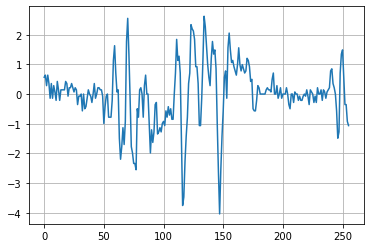

In [55]:
plt.plot(x[110,:,4])
plt.grid(True)

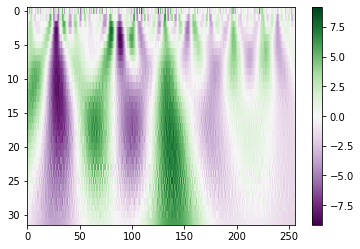

0


In [5]:
temp = 10
channel = 1
plt.imshow(cwtmatr[temp,:,:,channel], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,channel]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,channel]).max())
plt.colorbar()
plt.show()
print(y[temp])

In [93]:
#label = y[ind]
#label[label==2]=1
y.shape

(44530,)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras import callbacks, Model, models
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve,confusion_matrix,accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

In [24]:
def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.5,1,1.5],
    #              [1,0,1,1],
    #              [5,10,0,5],
    #              [1.,1.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,5.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

In [102]:
#ind = ((y[:20000]==1) | (y[:20000]==2) | (y[:20000]==3) | (y[:20000]==4) | (y[:20000]==6))
#y_02 = y[:20000]
#ind = ((y==1) | (y==2) | (y==3) | (y==4) | (y==6))
file = './processed data/cwt_W256_S32_Wc32_mexh_nm_no_G08_FoG_1_trial_1.hdf5'
with h5py.File(file,'r') as f:
    cwtmatr = f['features']
    y = f['labels'][...]
    ind1 = ((y==1) | (y==2) | (y==6))
    ind = np.where(ind1==True)
    print(ind)
    oc = OneHotEncoder()
    #y_02 = y.copy()
    y_02 = oc.fit_transform(y[ind1,np.newaxis]).toarray()
    #y_02[ind]=1
    X_full,X_test,y_full,y_test = train_test_split(cwtmatr[ind],y_02,test_size = 0.2,shuffle = True,random_state=123)
    #X_full,X_test,y_full,y_test= train_test_split(X_full1,y_full1,test_size = 0.2,shuffle = True,random_state=123)
    X_train,X_valid,y_train,y_valid= train_test_split(X_full,y_full,test_size = 0.2,random_state=555)

(array([  143,   144,   145, ..., 26275, 26276, 26277], dtype=int64),)


In [103]:
pd.Series(y).value_counts()
#X_test.shape

0    9631
2    9152
6    3992
1    3645
3      93
dtype: int64

In [104]:
input_ = layers.Input(shape=X_full.shape[1:])
#bn = layers.BatchNormalization()(input_)
max_pool = layers.MaxPooling2D((2,2))(input_)
#bn = layers.BatchNormalization()(input_)
conv1 = layers.Conv2D(16,(2,6),strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(max_pool)
act1 = layers.Activation('relu')(conv1)
#bn1 = layers.BatchNormalization()(act1)
max_pool1 = layers.MaxPooling2D((2,2))(act1)
conv2 = layers.Conv2D(32,(2,6),strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(max_pool1)
act2 = layers.Activation('relu')(conv2)
#bn2 = layers.BatchNormalization()(act2)
max_pool2 = layers.MaxPooling2D(2)(act2)
conv3 = layers.Conv2D(64,(2,6),strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(max_pool2)
act3 = layers.Activation('relu')(conv3)
#bn3 = layers.BatchNormalization()(act3)
max_pool3 = layers.MaxPooling2D(2)(act3)
conv4 = layers.Conv2D(128,(2,6),strides=(1,1),
                      kernel_initializer=TruncatedNormal(),
                      #use_bias=False,#activation='elu',
                      padding='same')(max_pool3)
act4 = layers.Activation('relu')(conv4)
#bn4 = layers.BatchNormalization()(act4)
max_pool4 = layers.MaxPooling2D(2)(act4)
flatten = layers.Flatten()(max_pool4)
dropout = layers.Dropout(0.2)(flatten)
layer1 = layers.Dense(256,activation = 'relu')(dropout)
dropout1 = layers.Dropout(0.2)(layer1)
layer2 = layers.Dense(128,activation = 'relu')(dropout1)
#dropout2 = layers.Dropout(0.2)(layer2)
output = layers.Dense(3,activation = 'softmax')(layer2)
model = keras.Model(inputs=[input_],outputs=[output])

In [105]:
#ind = ((y==0) | (y==2))
#bce = CategoricalCrossentropy()
model.compile(loss = 'categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])
#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(K.eval(y)[ind,tf.newaxis]).toarray()

In [106]:
cw = None#{0:2,1:1,2:10,3:2}
early_stopping = callbacks.EarlyStopping(patience = 10,monitor = 'val_accuracy', restore_best_weights=True)

In [107]:
history = model.fit(X_full,y_full,validation_data=[X_test,y_test],
                    epochs=300,batch_size=32,
                    class_weight=cw,
                    callbacks=[early_stopping]
                   )

Train on 13431 samples, validate on 3358 samples
Epoch 1/300
13431/13431 [==============================] - 64s 5ms/sample - loss: 0.7610 - accuracy: 0.6602 - val_loss: 0.6391 - val_accuracy: 0.7299
Epoch 2/300
13431/13431 [==============================] - 45s 3ms/sample - loss: 0.6069 - accuracy: 0.7394 - val_loss: 0.5666 - val_accuracy: 0.7531
Epoch 3/300
13431/13431 [==============================] - 47s 3ms/sample - loss: 0.5052 - accuracy: 0.7926 - val_loss: 0.4981 - val_accuracy: 0.8139
Epoch 4/300
13431/13431 [==============================] - 51s 4ms/sample - loss: 0.3968 - accuracy: 0.8365 - val_loss: 0.3744 - val_accuracy: 0.8532
Epoch 5/300
13431/13431 [==============================] - 46s 3ms/sample - loss: 0.2853 - accuracy: 0.8892 - val_loss: 0.2400 - val_accuracy: 0.9068
Epoch 6/300
13431/13431 [==============================] - 47s 3ms/sample - loss: 0.2009 - accuracy: 0.9257 - val_loss: 0.2468 - val_accuracy: 0.9056
Epoch 7/300
13431/13431 [==========================

In [104]:
model.evaluate(X_test,y_test)

534/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.6611357378155998, 0.7172285]

In [108]:
#y_pred = model.predict(X_test)

#oh_ec = OneHotEncoder()
#label = oh_ec.fit_transform(y_full[:,np.newaxis]).toarray()
#precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])
#y_pred = np.argmax(y_pred,axis=1)
#print(y_pred)
#y_pred = y_pred+1
#y_pred = oh_ec.fit_transform(y_pred[:,np.newaxis]).toarray()
#y_pred = oc.inverse_transform(y_pred)
#y_train_i = oc.inverse_transform(y_test)

y_pred_t=model.predict(X_test)
test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
#y_pred_v=model.predict(x_valid)
#valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
y_pred_ta=model.predict(X_full)
train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
print('test:%f'%test)
#print('valid:%f'%valid)
print('train:%f'%train)
print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
#print('valid: \n',metrics.confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))

test:0.992257
train:0.999851
train: 
 [[2936    0    0]
 [   0 7300    0]
 [   0    2 3193]]
test: 
 [[ 700    7    2]
 [   9 1841    2]
 [   4    2  791]]


In [109]:
file = 'G08_FoG_1_trial_1_emg.csv'
feature,label = dp.pipeline_cwt('./data/'+file,width = width, 
                                           stride=32,
                                           scaler=False,
                                           norm=True,
                                           width_c=32,
                                       same_label=True,
                                           dropna=True)
ind1 = ((label==1) | (label==2) | (label==6))
y_pred=model.predict(feature[ind1])
print(accuracy_score(label[ind1],oc.inverse_transform(y_pred>0.5)))
confusion_matrix(label[ind1],oc.inverse_transform(y_pred>0.5))

0.3444764224042506


array([[  85,  954,   63],
       [  92, 1321,  109],
       [ 227, 1516,  150]], dtype=int64)

In [21]:
#plt.plot(recall,precision)
confusion_matrix(y_train_i,y_pred)

array([[ 425,   38,    0,    6],
       [  51, 1022,    0,   10],
       [   0,    1,    6,    0],
       [   9,   12,    0,  562]], dtype=int64)

In [84]:
y_pred

array([[6.0590548e-03, 9.9391526e-01, 2.5762538e-05],
       [1.0573975e-08, 1.0000000e+00, 3.8397259e-09],
       [1.6229848e-10, 1.0000000e+00, 1.7472540e-13],
       ...,
       [9.2019298e-16, 1.0000000e+00, 1.2263473e-16],
       [3.9972323e-09, 1.0000000e+00, 1.0092542e-09],
       [1.5464315e-10, 1.0000000e+00, 3.6735908e-09]], dtype=float32)

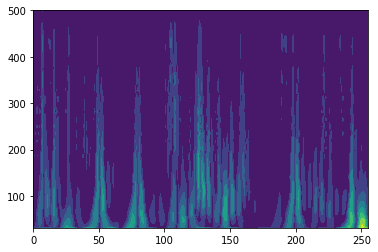

In [85]:
t = np.arange(0,256)
f=np.array([500.   , 484.375, 468.75 , 453.125, 437.5  , 421.875, 406.25 ,
       390.625, 375.   , 359.375, 343.75 , 328.125, 312.5  , 296.875,
       281.25 , 265.625, 250.   , 234.375, 218.75 , 203.125, 187.5  ,
       171.875, 156.25 , 140.625, 125.   , 109.375,  93.75 ,  78.125,
        62.5  ,  46.875,  31.25,32 ])
plt.contourf(t, f, abs(X_full[510,:,:,6]))

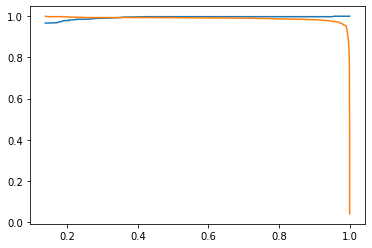

In [166]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [95]:
#model = load_model('./model/Mexh_W256_S32_WS32.h5')
ind = ((y2==1) | (y2==2) | (y2==3))
y_02=y2
y_02[ind]=1
model.evaluate(cwtmatr,y[25000:35000])

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.8236013696538722, 0.7228]

In [78]:
(model.predict(cwtmatr2).argmax(axis=1)==y_02).sum()

284

In [87]:
cwtmatr.shape

(20000, 32, 256, 8)

array([[ 651,    7],
       [   9, 1167]], dtype=int64)

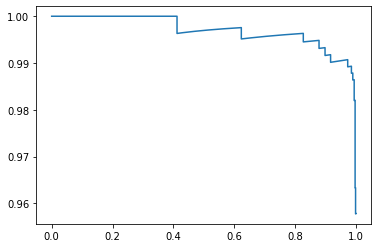

In [53]:
y_pred = model.predict(cwtmatr[ind])
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(y_02[:,np.newaxis]).toarray()
precision, recall, threshold = precision_recall_curve(label[:,0],y_pred[:,0])
plt.plot(recall,precision)
confusion_matrix(y_02,np.where(y_pred<0.5,1,0)[:,0])

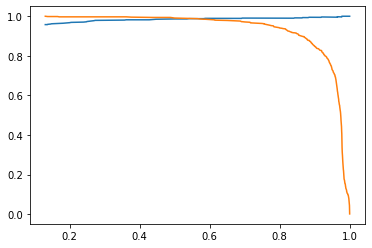

In [54]:
plt.plot(threshold,precision[:-1])
plt.plot(threshold,recall[:-1])

In [232]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 256, 8)]      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 256, 8)        32        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 128)      25728     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 64, 128)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 32, 64)         204864    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 2, 16, 64)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0   

(0, 1)

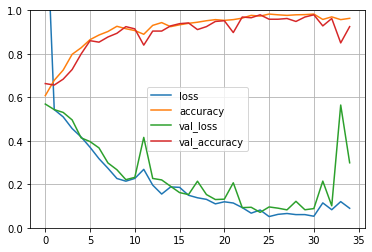

In [22]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)

In [39]:
model.save('./model/Mexh_W%d_S%d_WS%d.h5'%(width,stride,widths_scale))

# cnn2

In [2]:
path = './processed data/data_set_after_window_W256_S64_sameLabel_nm.hdf5'
with h5py.File(path,'r') as f:
    x = f['data'][...]
    y = f['label2'][...]

In [16]:
x = np.reshape(x,(-1,256,8,1))

In [3]:
y.shape

(16106,)

In [5]:
def train_model(model,feature,y,binary=True,file=None):
    if binary:
        ind = ((y==0)|(y==1)|(y==2)|(y==3)|(y==4)|(y==6))
        ind1 = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
        y_01 = y.copy()
        #ind1 = ((y_01==1)|(y_01==2)|(y_01==6))
        y_01[ind1] = 1
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:1,1:5}
    else:
        ind = ((y==1)|(y==2)|(y==6))
        #ind = ((y==1)|(y==6))
        y_01 = y[ind].copy()
        oc = OneHotEncoder()
        y_01 = oc.fit_transform(np.array(y_01)[:,np.newaxis]).toarray()
        cw = None#{0:5,1:1,2:1}#{0:2,1:1,2:10,3:2}
    x_full,x_test,y_full,y_test = train_test_split(np.array(feature)[ind,:],y_01,
                                                   test_size=0.2,
                                                   random_state=123,
                                                   shuffle=True)
    x_train,x_valid,y_train,y_valid = train_test_split(x_full,y_full,
                                                       test_size=0.25,
                                                       random_state=555,
                                                       shuffle=True)
    
    #sm = BorderlineSMOTE(random_state=50,kind='borderline-2')
    #sm = SMOTE(random_state=50)
    #print(y_full.shape)
    #x_full,y_full = sm.fit_resample(x_full,y_full)
    #print(y_full_n.shape)
    #sc = StandardScaler(with_mean=True)
    #sc = MinMaxScaler()
    #x_train = sc.fit_transform(x_full)
    #pca = PCA(n_components=100)
    #x_train = pca.fit_transform(x_train)
    #x_valid = sc.transform(x_valid)
    #x_test = sc.transform(x_test)
    #x_test = pca.transform(x_test)
    x_train = x_full
    
    early_stopping = callbacks.EarlyStopping(patience = 10,
                                             monitor = 'val_loss', 
                                             restore_best_weights=True)
    history = model.fit(x_train,y_full,validation_data=[x_test,y_test],
                        epochs=300,batch_size=32,class_weight=cw,
                        callbacks=[early_stopping],
                        shuffle=True)
    
    if binary:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #test = accuracy_score(y_test,y_pred_t>0.5)
        
        #y_pred_v=model.predict(x_valid)
        #valid = accuracy_score(y_valid,np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))
        #train = accuracy_score(y_full,y_pred_ta>0.5)
        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
        
        #print('train: \n',metrics.confusion_matrix(y_full,y_pred_ta>0.5))
        #print('test: \n',metrics.confusion_matrix(y_test,y_pred_t>0.5))

    else:
        y_pred_t=model.predict(x_test)
        test = accuracy_score(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1))
        #y_pred_v=model.predict(x_valid)
        #valid = metrics.accuracy_score(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1))
        y_pred_ta=model.predict(x_train)
        train = accuracy_score(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1))        
        print('train: \n',confusion_matrix(np.argmax(y_full,axis=1),np.argmax(y_pred_ta,axis=1)))
        #print('valid: \n',confusion_matrix(np.argmax(y_valid,axis=1),np.argmax(y_pred_v,axis=1)))
        print('test: \n',confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_t,axis=1)))
    print('test:%f'%test)
    #print('valid:%f'%valid)
    print('train:%f'%train)
    if file != None:
        model.save_model(file)
    return train,test

def test_model(model,feature,y):
    ind = ((y==4)|(y==1)|(y==2)|(y==3)|(y==6))
    y_01 = y.copy()
    y_01[ind] = 1
    y_pred=model.predict_classes(feature)
    test = accuracy_score(y_01,y_pred)
    print(confusion_matrix(y_01,y_pred))
    print('acc:%f'%test)
    return test

def sparse_cost_sensitive_loss (y_true,y_pred):
    #cost_matrix = tf.constant([[0,1.5,1,1.5],
    #              [1,0,1,1],
    #              [5,10,0,5],
    #              [1.,1.,1,0]])
    cost_matrix = tf.constant([[0,2.,2],
                  [1,0,1],
                  [1.0,1.,0]])
    batch_cost_matrix = tf.nn.embedding_lookup(cost_matrix, tf.argmax(y_true,axis=1))
    eps = 1e-6
    probability = tf.clip_by_value(y_pred, eps, 1-eps)
    cost_values = tf.math.log(1-probability)*batch_cost_matrix
    loss = tf.reduce_mean(-tf.reduce_sum(cost_values, axis=1))
    return loss

In [28]:
model = models.Sequential()
#input_ = layers.Input(shape=x.shape[1:])
model.add(keras.layers.InputLayer(input_shape=x.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(8,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(8,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2,2)))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(16,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(2))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(32,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        activation='relu',
                        padding='same'))
model.add(layers.Conv2D(32,(2,6),strides=(1,1),
                        #kernel_initializer=TruncatedNormal(),
                        #activation='relu',
                        padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D(2))
#model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256,activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3,activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])

In [29]:
train_model(model,x,y,binary=False)

Train on 8527 samples, validate on 2132 samples
Epoch 1/300
8527/8527 [==============================] - 40s 5ms/sample - loss: 0.9966 - accuracy: 0.5154 - val_loss: 0.9294 - val_accuracy: 0.5699
Epoch 2/300
8527/8527 [==============================] - 34s 4ms/sample - loss: 0.8888 - accuracy: 0.5996 - val_loss: 0.8192 - val_accuracy: 0.6379
Epoch 3/300
8527/8527 [==============================] - 27s 3ms/sample - loss: 0.8029 - accuracy: 0.6465 - val_loss: 0.7872 - val_accuracy: 0.6618
Epoch 4/300
8527/8527 [==============================] - 28s 3ms/sample - loss: 0.7316 - accuracy: 0.6846 - val_loss: 0.7592 - val_accuracy: 0.6792
Epoch 5/300
8527/8527 [==============================] - 28s 3ms/sample - loss: 0.6748 - accuracy: 0.7095 - val_loss: 0.7786 - val_accuracy: 0.6712
Epoch 6/300
8527/8527 [==============================] - 29s 3ms/sample - loss: 0.6037 - accuracy: 0.7481 - val_loss: 0.7711 - val_accuracy: 0.6829
Epoch 7/300
8527/8527 [==============================] - 33s 4ms

KeyboardInterrupt: 

In [8]:
test_model(model,x[12000:20000],y[12000:20000])

[[1074  350]
 [1284 1398]]
acc:0.602046


0.6020457866536776

In [83]:
np.concatenate([y[:14000],y[20000:25000]]).shape

(19000,)

In [14]:
x[20000:25000].shape

(0, 256, 8)